# PMF Implementation

In [ ]:
import torch
import torchvision
import torch.nn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from tables.table import NoSuchNodeError
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
import copy
warnings.filterwarnings('ignore')

In [ ]:
INPUT_DIR='/content/drive/MyDrive/DSAIL/data'
OUTPUT_DIR='/content/drive/MyDrive/DSAIL/data'

In [ ]:
ratings = pd.read_csv(os.path.join(INPUT_DIR, 'ratings.csv'))

In [ ]:
ratings_df = ratings.drop(columns=['timestamp'])
ratings_df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [ ]:
#userId x moveId , cell : rating인 matrix

table_df = ratings_df.pivot_table(index='userId', columns='movieId', values ='rating')
df_matrix = table_df.to_numpy()

In [ ]:
#Nan이 아닌 애들의 위치를 뽑아서

locate = []
for i in range (len(df_matrix)):
  for j in range (len(df_matrix[0])):
    if not(math.isnan(df_matrix[i][j])):
      locate.append((i,j))
data = np.array(locate)
data = data.astype(int)

#그 뽑은 위치들 중 train/test(validation) split
train_data, test_data = train_test_split(data,test_size = 0.25, random_state = 42)

train_df = np.zeros(df_matrix.shape)
test_df = np.zeros(df_matrix.shape)

for tup in train_data:
  train_df[tup[0]][tup[1]] = df_matrix[tup[0]][tup[1]]
for tup in test_data:
  test_df[tup[0]][tup[1]] = df_matrix[tup[0]][tup[1]]

print(train_df)

[[4.  0.  4.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [2.5 2.  2.  ... 0.  0.  0. ]
 [3.  0.  0.  ... 0.  0.  0. ]
 [5.  0.  0.  ... 0.  0.  0. ]]


In [ ]:
class PMF():
  def __init__(self, train_R = None, test_R = None, constrained = False ):
    self.num_feat = 30
    self.momentum = 0.9
    self.learning_rate = 0.0005
    self.itr = 80
    self.lambda_V = 0.001
    self.lambda_U = 0.001
    self.lambda_W = 0.001
    self.train_R = train_R
    self.test_df = test_R
    self.constrained = constrained

    self.train_I = copy.deepcopy(self.train_R)
    self.train_I[self.train_I>0] = 1

    rand_num1 = np.random.RandomState(100)
    rand_num2 = np.random.RandomState(101)
    #0.1이 필요한가???
    self.U = rand_num1.randn(self.num_feat,train_R.shape[0])
    self.V = rand_num1.randn(self.num_feat,train_R.shape[1])
    self.W = rand_num2.randn(self.num_feat,train_R.shape[1])

    self.Y = None
    self.sigma_I = np.dot(self.train_I,np.ones(self.train_R.shape[1]))
    self.sigma_I[self.sigma_I == 0] = np.inf


  def loss_function(self):
    if not self.constrained:
      return 0.5*np.sum((self.train_I*(self.train_R-np.dot(self.U.T,self.V))**2)) + 0.5*(self.lambda_U)*np.sum(np.square(self.U)) + 0.5*(self.lambda_V)*np.sum(np.square(self.V))
    else:
      ##sigmoid 대입할수는 없을까?
      #return 0.5*np.sum(self.I*(self.train_R-np.dot(self.U.T + (np.dot(self.W, self.I.T)/self.sigma_I).T, self.V))**2) + 0.5*self.lambU*np.sum(np.square(self.U)) + 0.5*self.lambV*np.sum(np.square(self.V))+0.5*self.lambW*np.sum(np.square(self.W))
      return 0.5 * np.sum(self.train_I*(self.train_R- np.dot(((self.U+(np.dot(self.W,self.train_I.T)/self.sigma_I)).T),self.V))**2) + (self.lambda_U/2)*np.sum((self.U)**2) + (self.lambda_V/2)*np.sum((self.V**2)) + (self.lambda_W/2)*np.sum((self.W)**2)

  ###########################################################
  def predict(self,test_data):
    #constrain이면 Y항 나와야하고 그렇지 않으면 U항만써서 V와 곱한다.
    pred_value = []
    if(self.constrained):
      sigma_I = np.dot(self.train_I,np.ones(self.train_R.shape[1]))
      sigma_I[self.sigma_I == 0] = np.inf
      self.Y = self.U + (np.dot(self.W, self.train_I.T)/sigma_I)
      for locate in test_data:
        pred_value.append(np.dot(self.Y[:,locate[0]],self.V[:,locate[1]]))
    else:
      for locate in test_data:
        pred_value.append(np.dot(self.U[:,locate[0]],self.V[:,locate[1]]))

    return np.array(pred_value)

    pass

  def fit(self, test_data, df_matrix):
    train_mse = []
    test_mse = []

    mmt_U = np.zeros(self.U.shape)
    mmt_V = np.zeros(self.V.shape)

    if not self.constrained:
      for i in range (self.itr):
        dv_u = - (np.dot((self.train_I*(self.train_R - np.dot(self.U.T,self.V))),self.V.T)).T + self.lambda_U*self.U
        dv_v = - (np.dot(self.U, (self.train_I*(self.train_R - np.dot(self.U.T, self.V))))) + self.lambda_V*self.V

        mmt_U = (self.momentum * mmt_U) + self.learning_rate * dv_u
        mmt_V = (self.momentum * mmt_V) + self.learning_rate * dv_v
        self.U = self.U - mmt_U * self.momentum
        self.V = self.V - mmt_V * self.momentum
        train_mse_loss = self.loss_function()
        train_mse.append(train_mse_loss)

        test_predicts = self.predict(test_data)
        test_data_values = df_matrix[test_data[:,0],test_data[:,1]]
        test_mse_value =np.sum(np.square(test_data_values-test_predicts))/len(test_data_values)
        test_mse.append(test_mse_value)

        print('traning iteration:{: d} ,loss:{: f}, test_rmse:{: f}'.format(i, train_mse_loss, test_mse_value))


    else:
      mmt_W = np.zeros(self.W.shape)
      for i in range(self.itr):

        dv_u = - (np.dot(self.train_I*(self.train_R-np.dot(self.U.T + (np.dot(self.W,self.train_I.T)/self.sigma_I).T,self.V)),self.V.T)).T + self.lambda_U*self.U
        dv_v = - np.dot(self.U ,(self.train_I*(self.train_R-np.dot(self.U.T + (np.dot(self.W, self.train_I.T)/self.sigma_I).T, self.V)))) + self.lambda_V*self.V
        #dv_v = - (np.dot(self.train_I*(self.train_R-np.dot(self.U.T + (np.dot((self.W,self.train_I.T)/self.sigma_I).T),self.V),self.U.T+(np.dot(self.W,self.train_I.T)/self.sigma_I).T))).T + self.lambda_V*self.V
        dv_w = - (np.dot((self.train_I*(self.train_R-np.dot(self.U.T + (np.dot(self.W,self.train_I.T)/self.sigma_I).T,self.V))).T, np.dot(self.train_I/self.sigma_I.reshape(-1,1),self.V.T))).T + self.lambda_W*self.W

        mmt_U = (self.momentum * mmt_U) + self.learning_rate * dv_u
        mmt_V = (self.momentum * mmt_V) + self.learning_rate * dv_v
        mmt_W = (self.momentum * mmt_W) + self.learning_rate * dv_w
        self.U = self.U - self.momentum * mmt_U
        self.V = self.V - self.momentum * mmt_V
        self.W = self.V - self.momentum * mmt_W
        train_mse_loss = self.loss_function()
        train_mse.append(train_mse_loss)

        test_predicts = self.predict(test_data)
        test_data_values = df_matrix[test_data[:,0],test_data[:,1]]
        test_mse_value =np.sum(np.square(test_data_values-test_predicts))/len(test_data_values)
        test_mse.append(test_mse_value)

        print('traning iteration:{: d} ,loss:{: f}, test_rmse:{: f}'.format(i, train_mse_loss, test_mse_value))



      pass

    return self.U, self.V, train_mse, test_mse








In [ ]:
model1 = PMF(train_R = train_df,test_R = test_df, constrained= True)
U1, V1, tr_loss_list1, test_rmse_list1 = model1.fit(test_data,df_matrix)
preds = model1.predict(test_data=test_data)
print("constrained_over")

traning iteration: 0 ,loss: 1136667.052514, test_rmse: 33.729737
traning iteration: 1 ,loss: 855306.617926, test_rmse: 27.681563
traning iteration: 2 ,loss: 741809.212584, test_rmse: 25.545931
traning iteration: 3 ,loss: 645791.276446, test_rmse: 23.153676
traning iteration: 4 ,loss: 599021.032536, test_rmse: 21.902327
traning iteration: 5 ,loss: 576758.737625, test_rmse: 21.617410
traning iteration: 6 ,loss: 536203.546449, test_rmse: 20.624702
traning iteration: 7 ,loss: 476095.526676, test_rmse: 18.648251
traning iteration: 8 ,loss: 418140.263607, test_rmse: 16.738096
traning iteration: 9 ,loss: 380510.495148, test_rmse: 15.709534
traning iteration: 10 ,loss: 357039.376854, test_rmse: 15.222851
traning iteration: 11 ,loss: 327841.417870, test_rmse: 14.434703
traning iteration: 12 ,loss: 288451.340138, test_rmse: 13.114077
traning iteration: 13 ,loss: 249349.895972, test_rmse: 11.647487
traning iteration: 14 ,loss: 219007.909421, test_rmse: 10.426591
traning iteration: 15 ,loss: 19875

In [ ]:
model2 = PMF(train_R = train_df,test_R = test_df, constrained= False)
U2, V2, tr_loss_list2, test_rmse_list2 = model2.fit(test_data,df_matrix)
preds2 = model2.predict(test_data=test_data)
print("unconstrained_over")

traning iteration: 0 ,loss: 1176026.613992, test_rmse: 33.320987
traning iteration: 1 ,loss: 884211.289551, test_rmse: 27.254428
traning iteration: 2 ,loss: 764043.036220, test_rmse: 25.239200
traning iteration: 3 ,loss: 664069.696177, test_rmse: 23.017458
traning iteration: 4 ,loss: 615115.576526, test_rmse: 21.940078
traning iteration: 5 ,loss: 590837.530112, test_rmse: 21.787894
traning iteration: 6 ,loss: 546526.739104, test_rmse: 20.840784
traning iteration: 7 ,loss: 479602.988177, test_rmse: 18.803948
traning iteration: 8 ,loss: 412998.192077, test_rmse: 16.770194
traning iteration: 9 ,loss: 369142.906776, test_rmse: 15.639757
traning iteration: 10 ,loss: 342918.136184, test_rmse: 15.053730
traning iteration: 11 ,loss: 310657.125414, test_rmse: 14.077749
traning iteration: 12 ,loss: 269417.333523, test_rmse: 12.584075
traning iteration: 13 ,loss: 233681.849894, test_rmse: 11.107118
traning iteration: 14 ,loss: 209214.546306, test_rmse: 9.984482
traning iteration: 15 ,loss: 189172

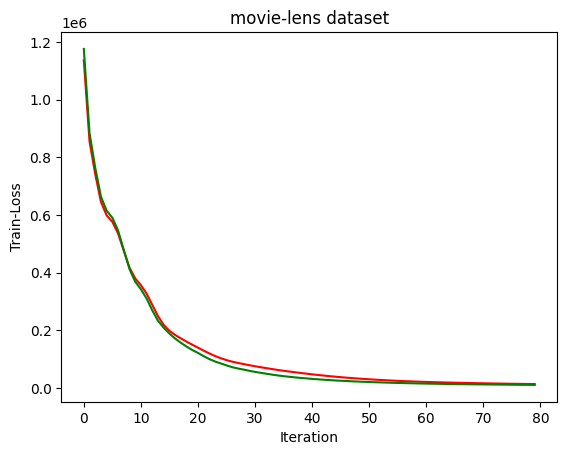

In [ ]:
plt.plot(tr_loss_list1, 'r')

plt.plot(tr_loss_list2, 'g')
plt.title('movie-lens dataset')
plt.xlabel('Iteration')
plt.ylabel('Train-Loss')

plt.show()

In [ ]:
torch.cuda.is_available()

False